In [1]:
# Tiina Manninen
# Implementation of our modified version of the astrocyte model by Dupont et al. (2011)
# Dupont, G., Lokenye, E. F. L., and Challiss, R. A. J. (2011). A model for Ca2+ oscillations stimulated
# by the type 5 metabotropic glutamate receptor: An unusual mechanism based on repetitive, reversible
# phosphorylation of the receptor. Biochimie 93, 2132–2138.

# Model implemented and ran using Jupyter Notebook.

# Model code used in publication: Manninen, T., Havela, R., and Linne, M.-L. (2017). 
# Reproducibility and comparability of computational models for astrocyte calcium excitability.
# Front. Neuroinform.

import numpy as np
import math

class ModelSystem:
    def __init__(self, params, stim):
        self.params = params
        self.stim = stim
    
    def computeDeriv(self, state, t):
        Ca, DAG, DIM, IP3, PKC, R_i = state
        modelPar = self.params
        modelStim = self.stim
        
        # Intermediate variables
        R_2 = modelPar.K_aff * DIM / modelStim(t) ** 2
        DIMp = (modelPar.R_tot - math.sqrt(modelPar.K_di * R_2) - 2 * R_2 - 2 * DIM) / 2
        IR_a = (1 - R_i) * IP3 ** 2/ (IP3 ** 2 + modelPar.K_I ** 2) \
             * Ca ** 3 / (Ca ** 3 + modelPar.K_act ** 3)
        
        # dx/dt 
        dCa_per_dt = modelPar.v_0 + (modelPar.b_1k_i + modelPar.k_i * IR_a) \
                   * (modelPar.Ca_tot - (modelPar.alpha + 1) * Ca) - \
                    modelPar.V_MP * Ca ** 2 / (Ca ** 2 + modelPar.K_P ** 2) - modelPar.k_l * Ca # This equation modified
        dDAG_per_dt = modelPar.k_PLC * DIM - modelPar.V_MD * DAG / (DAG +  modelPar.K_MD)  
        dDIM_per_dt = modelPar.V_M1 * DIMp / (DIMp + modelPar.K_A1) \
                    - modelPar.V_PKC * PKC * DIM / (DIM +  modelPar.K_A)
        dIP3_per_dt = modelPar.k_PLC * DIM - modelPar.k_1 * IP3
        dPKC_per_dt = modelPar.k_act * DAG / (DAG + modelPar.K_AD) * (1 - PKC) - modelPar.k_des * PKC
        dR_i_per_dt = modelPar.k_iplus * Ca ** 4 * (1 - R_i) \
                    * modelPar.K_act ** 3 / (modelPar.K_act ** 3 + Ca ** 3) - modelPar.k_iminus * R_i
       
        deriv = [dCa_per_dt, dDAG_per_dt, dDIM_per_dt, dIP3_per_dt, dPKC_per_dt, dR_i_per_dt]
        return deriv  

In [2]:
class ModelParameters:
    alpha = 0.1       # 1, This parameter added from Dupont 1997, 2000, needed because Ca equation was modified  
    b_1k_i = 7.5e-4   # uM/s
    Ca_tot = 80       # uM,This parameter added from Dupont 1997, 2000, needed because Ca equation was modified
    k_1 = 0.12        # 1/s
    K_A = 5e-4        # uM
    K_A1 = 5e-4       # uM
    k_act = 0.2       # 1/s
    K_act =  0.34     # uM
    K_AD = 0.06       # uM
    K_aff = 2         # uM^2
    k_des = 0.2       # 1/s
    K_di = 0.1        # uM 
    k_i = 7.5         # uM/s
    K_I = 0.4         # uM
    k_iplus = 25      # 1/(um^4 s)
    k_iminus = 0.0025 # 1/s
    k_l = 0.0025      # 1/s
    K_MD = 0.012      # uM
    K_P = 0.4         # uM
    k_PLC = 1.25      # 1/s
    R_tot = 0.075     # uM
    v_0 = 0.025       # uM/s
    V_M1 = 0.05       # uM/s
    V_MD = 0.0325     # uM/s
    V_MP = 2          # uM/s
    V_PKC = 0.2       # uM/s

In [3]:
def baseStim(t, minGlu = 2e-3, maxGlu = 5, duration = 62.5, period = 125, peaks = 2, startTime = 62.5):
    if (t < startTime):
        return minGlu
    if (t >= startTime + peaks * period):
        return minGlu
    
    # Compute phase
    ph = t - startTime
    ph -= np.floor(ph / period) * period
    
    if (ph < duration):
        return maxGlu
    
    return minGlu

In [4]:
params = ModelParameters()
modelStim_1 = lambda t: 1e-1    # uM
modelStim_2 = lambda t: 2.5     # uM
modelStim_3 = lambda t: 8       # uM
modelStim_4 = baseStim          # uM
modelStim_5 = lambda t: baseStim(t, duration = 5, period = 15, peaks = 7, startTime = 100)   # uM
modelStim_6 = lambda t: baseStim(t, duration = 1, period = 6, peaks = 7, startTime = 100)    # uM

mySys_1 = ModelSystem(params, modelStim_1)
mySys_2 = ModelSystem(params, modelStim_2)
mySys_3 = ModelSystem(params, modelStim_3)
mySys_4 = ModelSystem(params, modelStim_4)
mySys_5 = ModelSystem(params, modelStim_5)
mySys_6 = ModelSystem(params, modelStim_6)

In [5]:
from scipy.integrate import odeint
initial = [0.1, 25e-3, 14e-3, 0.2, 0.2, 0.9898] # uM, uM, uM, uM,, 1, 1

Tmax = 300
dt = 0.1
t = np.arange(0,Tmax,dt)

data_1 = odeint(mySys_1.computeDeriv, initial, t)
data_2 = odeint(mySys_2.computeDeriv, initial, t)
data_3 = odeint(mySys_3.computeDeriv, initial, t)
data_4 = odeint(mySys_4.computeDeriv, initial, t) 
data_5 = odeint(mySys_5.computeDeriv, initial, t)
data_6 = odeint(mySys_6.computeDeriv, initial, t, hmax=0.0005)

Populating the interactive namespace from numpy and matplotlib


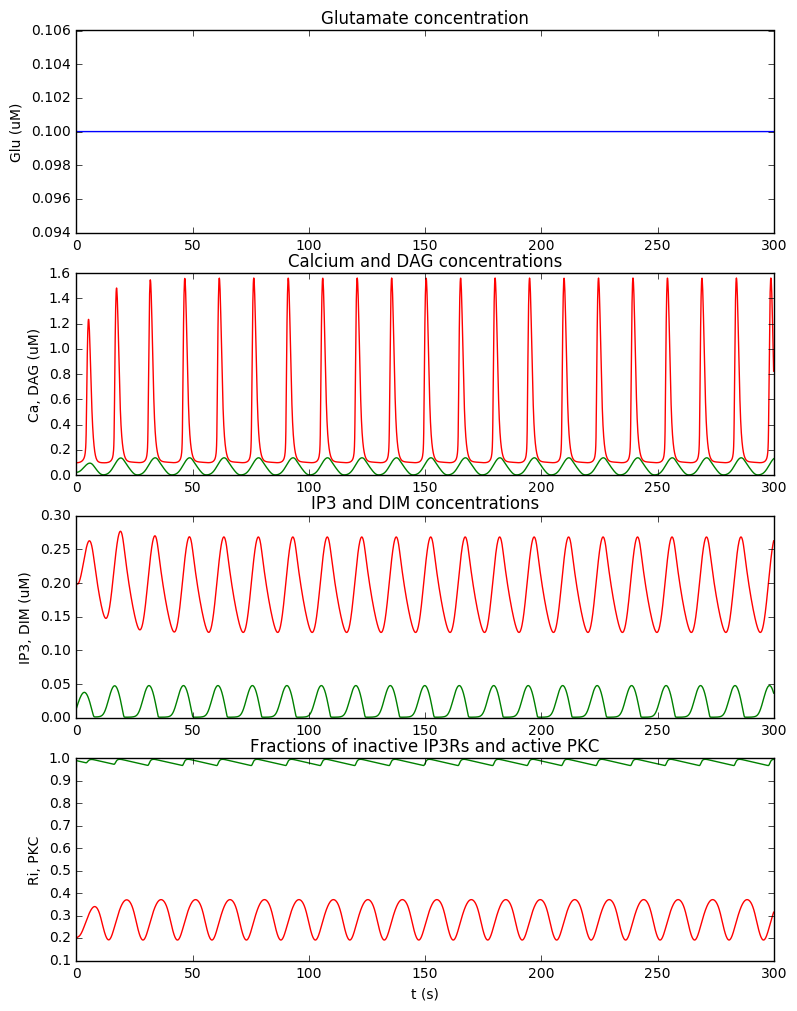

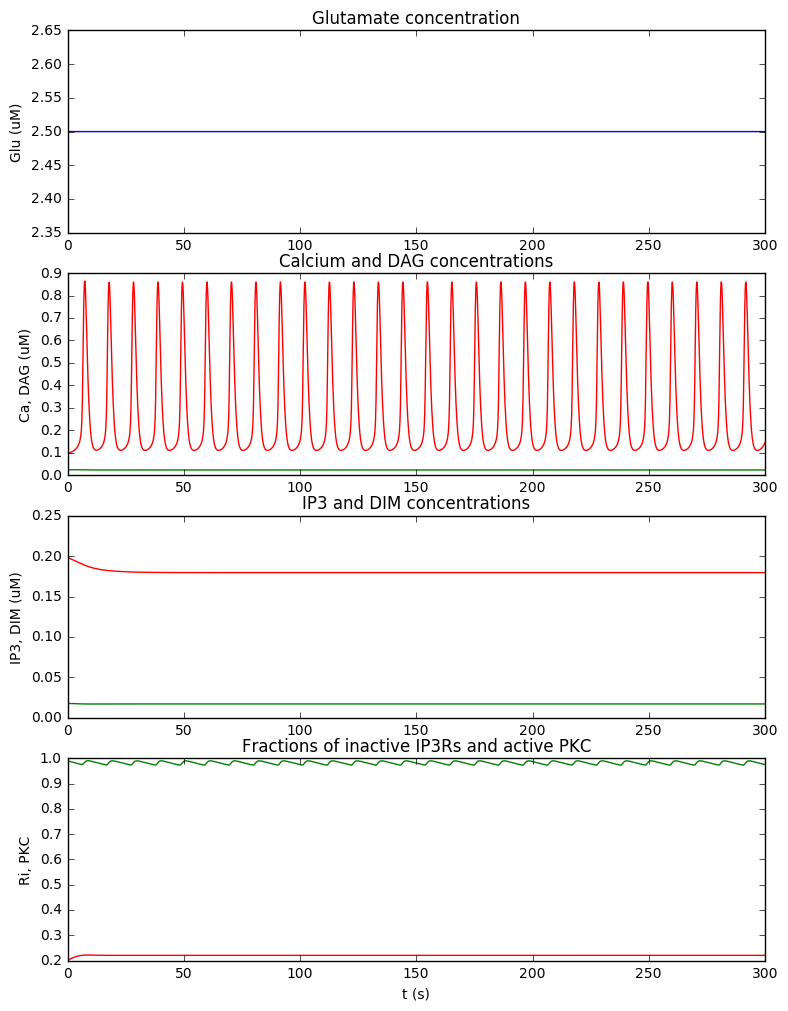

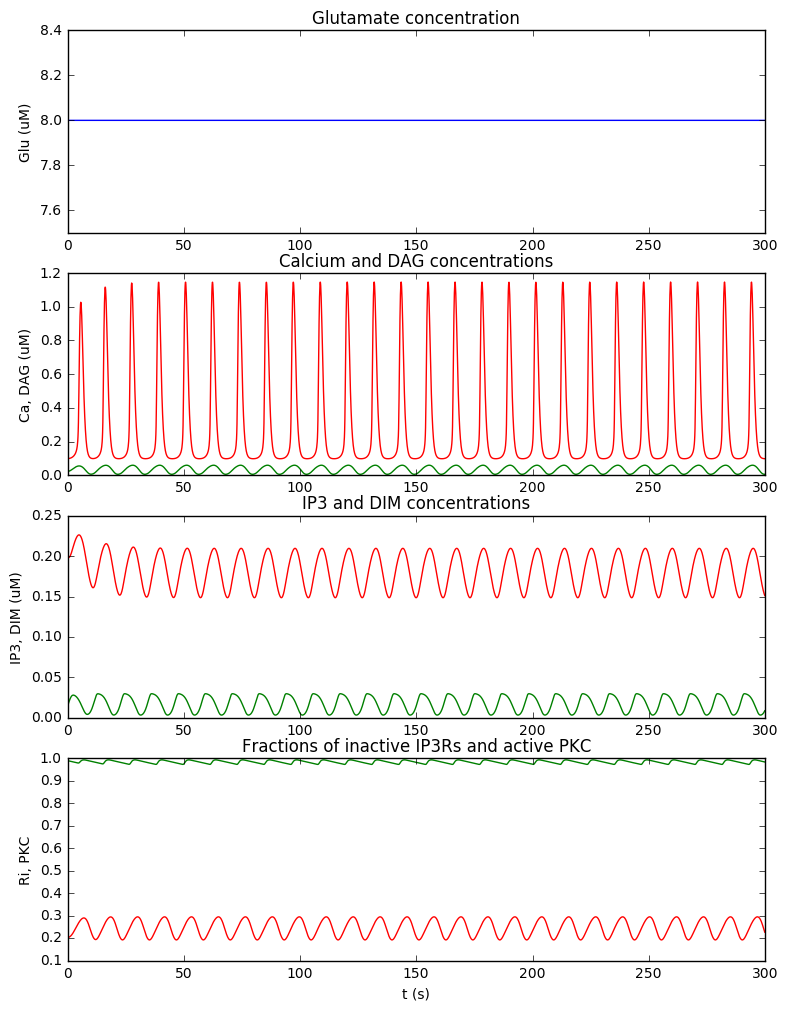

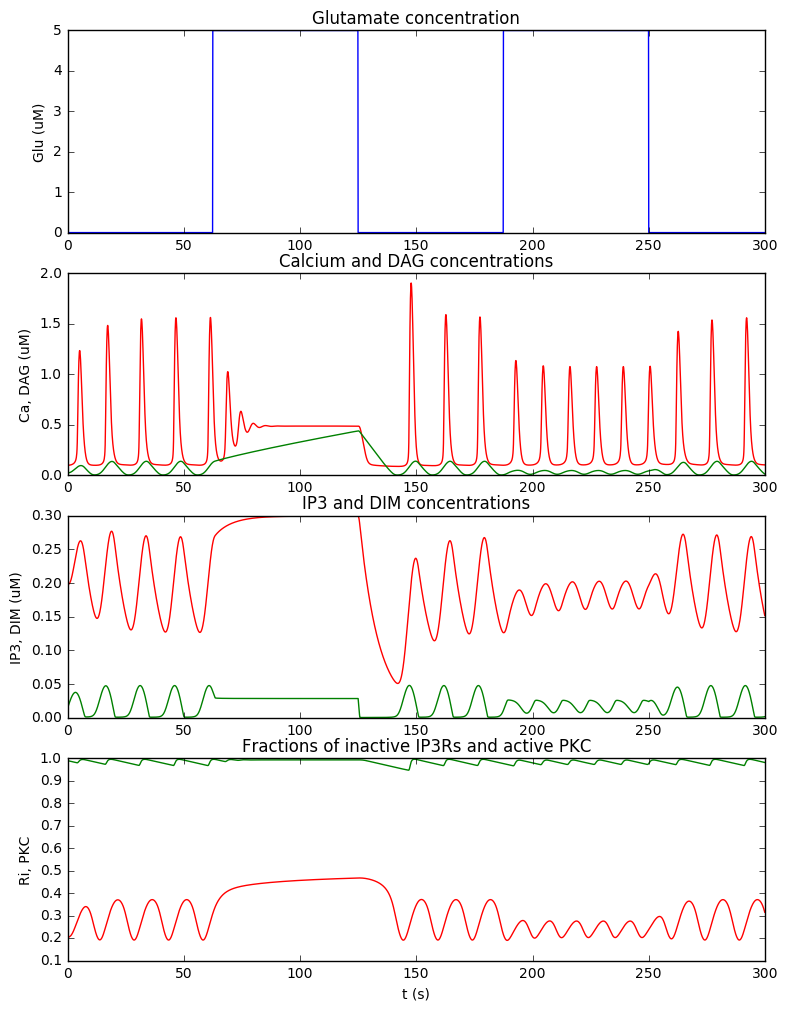

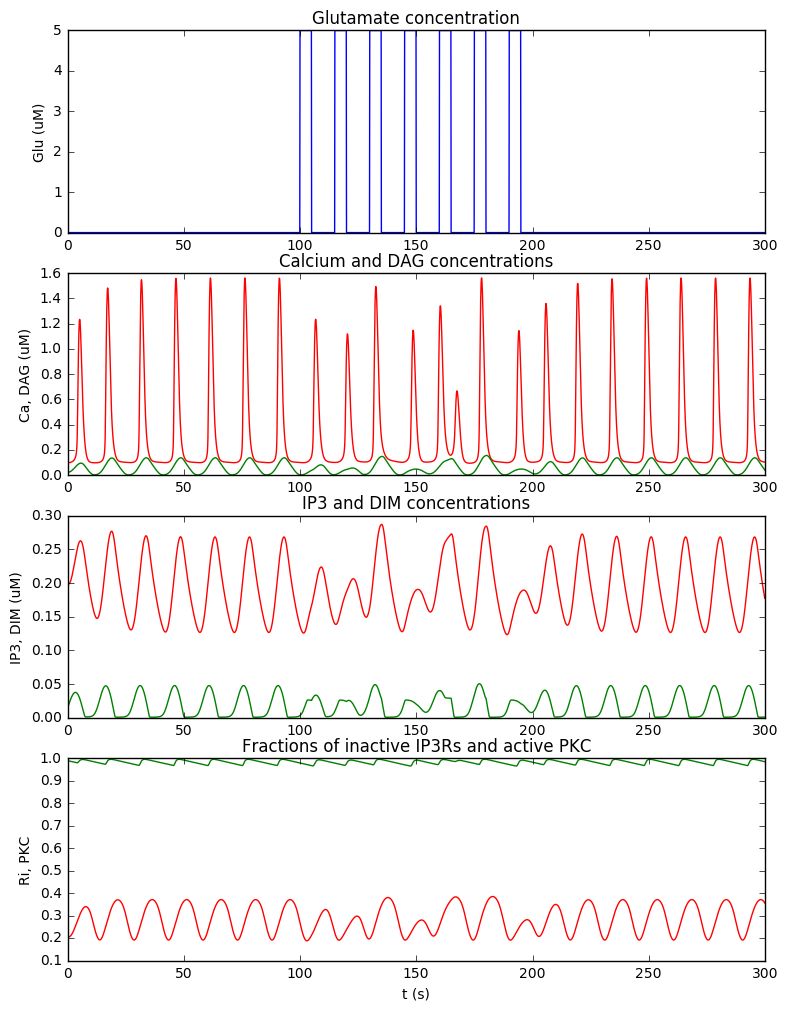

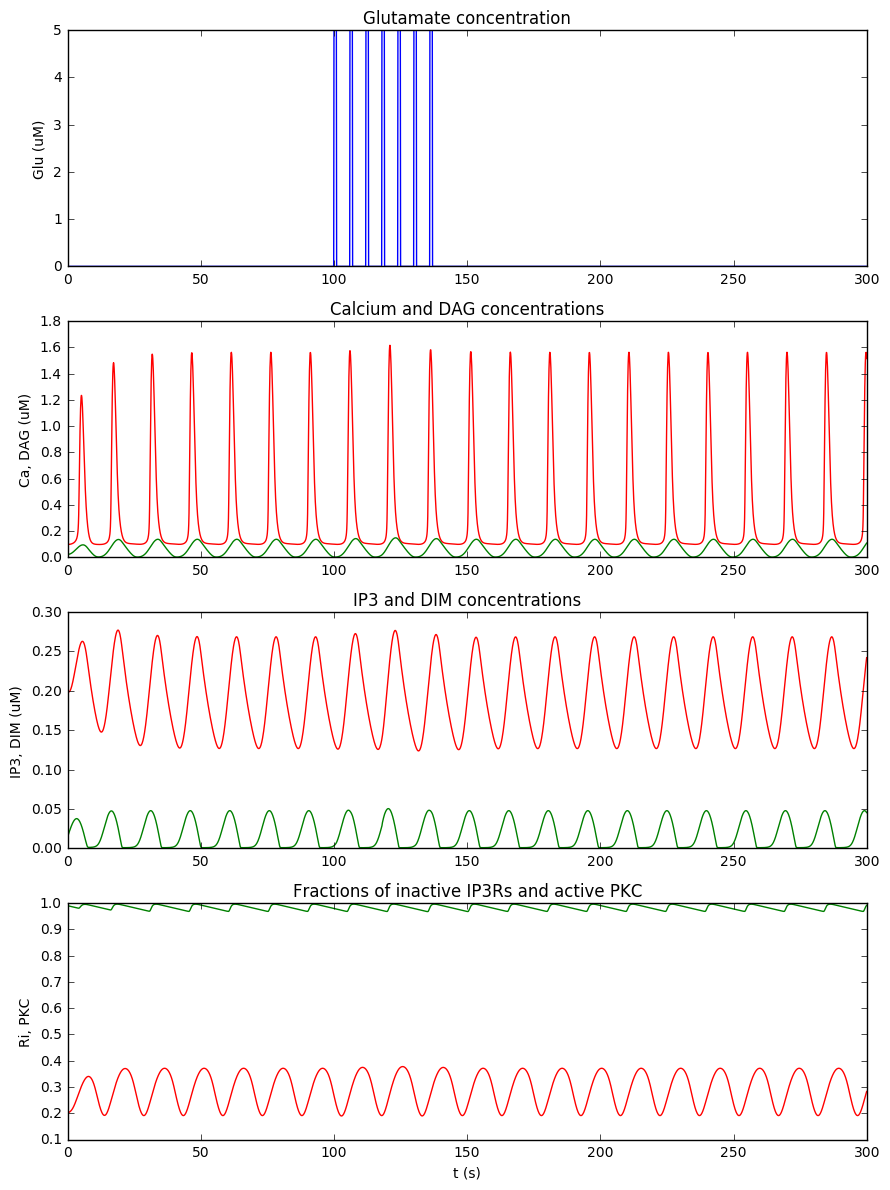

In [6]:
%pylab inline
import matplotlib.pyplot as plt

for pic in [(modelStim_1, data_1), (modelStim_2, data_2), (modelStim_3, data_3), (modelStim_4, data_4), (modelStim_5, data_5), (modelStim_6, data_6)]:
    modelStim_f, data_f = pic
    plt.figure(figsize=(9, 12), dpi=200)
    plt.subplot(4,1,1)
    plt.plot(t, list(map(modelStim_f, t)))
    plt.title('Glutamate concentration')
    plt.ylabel('Glu (uM)')
    
    plt.subplot(4,1,2)
    plt.plot(t, data_f[:,0],'r', t, data_f[:,1], 'g')
    plt.title('Calcium and DAG concentrations')
    plt.ylabel('Ca, DAG (uM)')

    plt.subplot(4,1,3)
    plt.plot(t, data_f[:,3], 'r', t, data_f[:,2], 'g')
    plt.title('IP3 and DIM concentrations')
    plt.ylabel('IP3, DIM (uM)')

    plt.subplot(4,1,4)
    plt.plot(t, data_f[:,4], 'r', t, data_f[:,5], 'g')
    plt.title('Fractions of inactive IP3Rs and active PKC')
    plt.ylabel('Ri, PKC')
    plt.xlabel('t (s)')

plt.tight_layout()


np.savetxt('Modified_Dupont2011_constantstim_0_1uM.csv', (t, list(map(modelStim_1, t)), data_1[:,0], data_1[:,1], data_1[:,2], data_1[:,3], data_1[:,4], data_1[:,5]),delimiter=',')
np.savetxt('Modified_Dupont2011_constantstim_2_5uM.csv', (t, list(map(modelStim_2, t)), data_2[:,0], data_2[:,1], data_2[:,2], data_2[:,3], data_2[:,4], data_2[:,5]),delimiter=',')
np.savetxt('Modified_Dupont2011_constantstim_8uM.csv', (t, list(map(modelStim_3, t)), data_3[:,0], data_3[:,1], data_3[:,2], data_3[:,3], data_3[:,4], data_3[:,5]), delimiter=',')
np.savetxt('Modified_Dupont2011_DePittastim.csv', (t, list(map(modelStim_4, t)), data_4[:,0], data_4[:,1], data_4[:,2], data_4[:,3], data_4[:,4], data_4[:,5]), delimiter=',')
np.savetxt('Modified_Dupont2011_pulsestim_5s_10s.csv', (t, list(map(modelStim_5, t)), data_5[:,0], data_5[:,1], data_5[:,2], data_5[:,3], data_5[:,4], data_5[:,5]), delimiter=',')
np.savetxt('Modified_Dupont2011_pulsestim_1s_5s.csv', (t, list(map(modelStim_6, t)), data_6[:,0], data_6[:,1], data_6[:,2], data_6[:,3], data_6[:,4], data_6[:,5]), delimiter=',')